In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from overreact import simulate

sns.set(context="notebook", style="white", palette="colorblind")
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
plt.rcParams["figure.dpi"] = 120

## More complex examples

For more complex examples, any kinetics scheme can be written as

$$\dot{y} = A r(y)$$

where $\dot{y}$ is the (vector) time derivative of compound concentrations, $A$ is the matrix of reaction coefficients ($A_{ij}$ is the stoichiometric coefficient of the i-th compound in the j-th reaction, possibly zero) and $r$ is the vector of reaction rates ($r_j$ is the reaction rate of the j-th reaction), which depends only on the vector $y$ (and possibly fixed parameters such as a vector of reaction rate constants $k$).

For example, the system above would be:

$$\dot{y} = \begin{bmatrix}
\frac{dA}{dt} \\
\frac{dB}{dt}
\end{bmatrix}
%
\qquad
%
A = \begin{bmatrix}
-1 \\
1
\end{bmatrix}
%
\qquad
%
r = \begin{bmatrix}
k_f A
\end{bmatrix}$$

In [3]:
A = np.array([[-1.], [1.]])
k = 1.0

def dydt(t, y):
    return np.dot(A, np.array([k * y[0]]))

In [4]:
t, y = simulate.get_y(dydt, y0=[1., 0.])

In [5]:
%timeit t, y = simulate.get_y(dydt, y0=[1., 0.])

1.68 ms ± 20.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


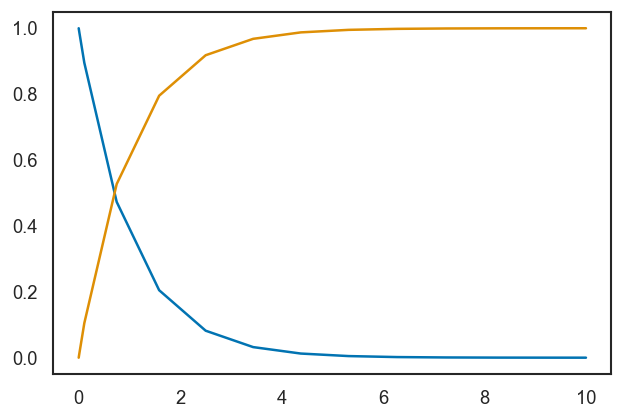

In [6]:
plt.plot(t, y[0], label="A")
plt.plot(t, y[1], label="B")

## The general case

The vector $r$ is, assuming elementary processes ($A_{ij}$ is negative if the i-th compound is a reactant in the j-th reaction, see examples above):

$$r_j = k_j \prod_i^\text{reactants} y_i^{-A_{ij}}$$

The above, together with $\dot{y} = A r(y)$, gives rise to the following new definition.

In [7]:
def dydt(t, y):
    r = k * np.prod(np.power(y, np.where(A > 0, 0, -A).T), axis=1)
    return np.dot(A, r)

In [8]:
t, y = simulate.get_y(dydt, y0=[1., 0.])

In [9]:
%timeit t, y = simulate.get_y(dydt, y0=[1., 0.])

3.36 ms ± 71.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


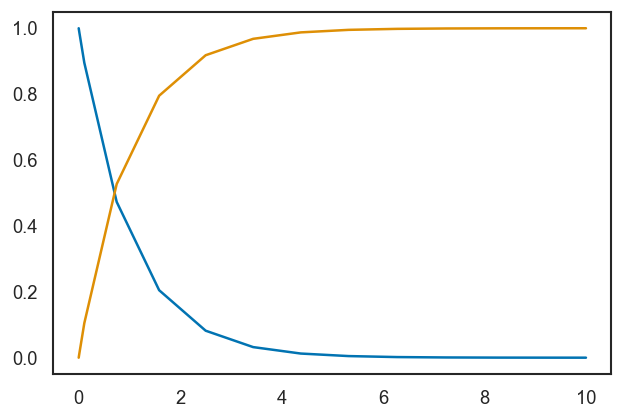

In [10]:
plt.plot(t, y[0], label="A")
plt.plot(t, y[1], label="B")

## Michaelis-Menten

A Michaelis-Menten-like system can be seen below (see [here](https://en.wikipedia.org/wiki/Petersen_matrix#Example)). Observe that the only inputs to the model are matrix $A$ and vector $k$.

In [11]:
              # A   B   S   E  ES   P
A = np.array([[-1, -2, +1,  0,  0,  0],
              [ 0,  0, -1, -1, +1,  0],
              [ 0,  0, +1, +1, -1,  0],
              [ 0,  0,  0, +1, -1, +1]]).T
            # k1     kf    kr kcat
k = np.array([1., 1000., 100., 10.])

# TODO: scipy 1.4+ will support passing args from solve_ivp, but for now let's do something rather mundane here
def dydt(t, y):
    r = k * np.prod(np.power(y, np.where(A > 0, 0, -A).T), axis=1)
    return np.dot(A, r)

In [12]:
t, y = simulate.get_y(dydt, y0=[1., 1., 0., 0.1, 0., 0.], method="BDF")

In [13]:
%timeit t, y = simulate.get_y(dydt, y0=[1., 1., 0., 0.1, 0., 0.], method="BDF")

20.9 ms ± 233 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


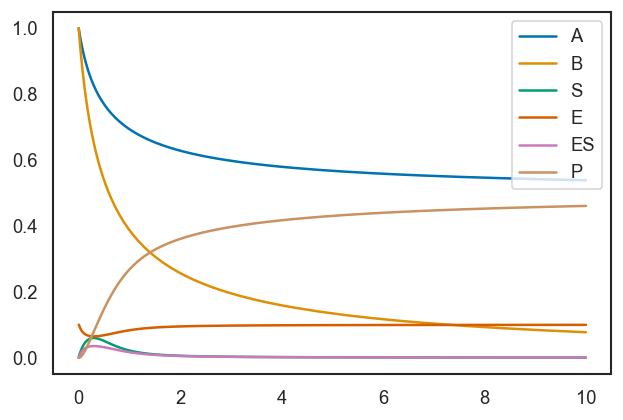

In [14]:
plt.plot(t, y[0], label="A")
plt.plot(t, y[1], label="B")
plt.plot(t, y[2], label="S")
plt.plot(t, y[3], label="E")
plt.plot(t, y[4], label="ES")
plt.plot(t, y[5], label="P")
plt.legend()

## Summary

To summarise, the system of ODEs we want to solve is

$$\dot{y} = A r(y)$$

with reaction rates

$$r_j = k_j \prod_i^\text{reactants} y_i^{-A_{ij}}$$

Everything is set. What's left is a method for obtaining the quantities $A$ (reaction coefficients) and $k$ (reaction rate constants).